In [1]:
import psycopg2
from dotenv import load_dotenv
import os

load_dotenv()

conn = psycopg2.connect(
    user=os.getenv("USER"),
    password=os.getenv("password"),
    host=os.getenv("HOST"),
    dbname=os.getenv("DBNAME")
)

In [2]:
import pandas as pd
 
temp_readings = pd.read_sql_query("SELECT * FROM public.temp_readings", conn)
fire_alerts = pd.read_sql_query("SELECT * FROM public.fire_alerts", conn)
tweets = pd.read_sql_query("SELECT * FROM public.tweets", conn)

/var/folders/sw/tz1yk8m16t9d_3n6kwxkbvrc0000gn/T/ipykernel_23139/38418671.py:3: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  temp_readings = pd.read_sql_query("SELECT * FROM public.temp_readings", conn)
/var/folders/sw/tz1yk8m16t9d_3n6kwxkbvrc0000gn/T/ipykernel_23139/38418671.py:4: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  fire_alerts = pd.read_sql_query("SELECT * FROM public.fire_alerts", conn)
/var/folders/sw/tz1yk8m16t9d_3n6kwxkbvrc0000gn/T/ipykernel_23139/38418671.py:5: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
 

In [3]:
temp_readings

,day,xy,temperature,id
0,1,"(0,0)",54,0
1,1,"(0,1)",51,1
2,1,"(0,2)",48,2
3,1,"(0,3)",58,3
4,1,"(0,4)",65,4
...,...,...,...,...
2294094,2549,"(29,24)",38,2294094
2294095,2549,"(29,25)",52,2294095
2294096,2549,"(29,26)",46,2294096
2294097,2549,"(29,27)",51,2294097


In [4]:
tweets

,day,xy,score,content,id
0,1,"(0,5)",None,to his brothers commanded him to remain succee...,0
1,1,"(0,5)",None,country to surat might go from thence to basso...,1
2,1,"(0,5)",None,to it was obliged to let it lie where it was a...,2
3,1,"(0,5)",None,found cure both for soul and body opened the c...,3
4,1,"(0,6)",None,means indeed the russians travel more in winte...,4
...,...,...,...,...,...
1711158,2549,"(29,27)",None,of her own mamma she was thoughtful for moment...,1711158
1711159,2549,"(29,27)",None,boat with orders to secure her and bring away ...,1711159
1711160,2549,"(29,27)",None,for the expedition ernest begged to be of the ...,1711160
1711161,2549,"(29,27)",None,in order to act the rebel to their authority a...,1711161


In [5]:
fire_alerts

,event_day,notification_day,xy,id
0,29,32,"(1,25)",0
1,34,37,"(9,24)",1
2,38,41,"(20,24)",2
3,39,42,"(0,23)",3
4,39,42,"(28,7)",4
...,...,...,...,...
5600,2332,2335,"(27,7)",5600
5601,2333,2336,"(0,2)",5601
5602,2334,2337,"(13,9)",5602
5603,2340,2343,"(2,17)",5603


# Experiment #1: Predicting fire alerts using temperature readings
Every sector at every day has a temperature reading, while only some sectors have messages. To start, we'll try to predict fire alerts on the day of using temperature readings only from the past 7 days.

In [6]:
from tqdm import tqdm

# create samples from the temperatures in X from the outputs in y
# the X has the temperature at a day index+1 (idx 0 = day 1)
# the y has the list of days that have fire alerts
# each sample should input 7 days, and output 1 or 0 for whether the 7th day has a fire alert
samples = []

for coord in tqdm(temp_readings['xy'].unique()):
    temp = temp_readings[temp_readings['xy'] == coord]
    fire = fire_alerts[fire_alerts['xy'] == coord]
    X = list(temp['temperature'])
    y = list(fire['event_day'])
    for i in range(7, len(X)):
        samples.append((X[i-7:i], 1 if i in y else 0))


100%|██████████| 900/900 [01:06<00:00, 13.59it/s]


In [7]:
import numpy as np

samples_x, samples_y = zip(*samples)
samples_x, samples_y = np.array(samples_x), np.array(samples_y)

len(samples_x)

2287799

In [8]:
from imblearn.over_sampling import SMOTE

# correct any imbalance before training
smote = SMOTE()
samples_x, samples_y = smote.fit_resample(samples_x, samples_y)

(array([2282194.,       0.,       0.,       0.,       0.,       0.,
              0.,       0.,       0., 2282194.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

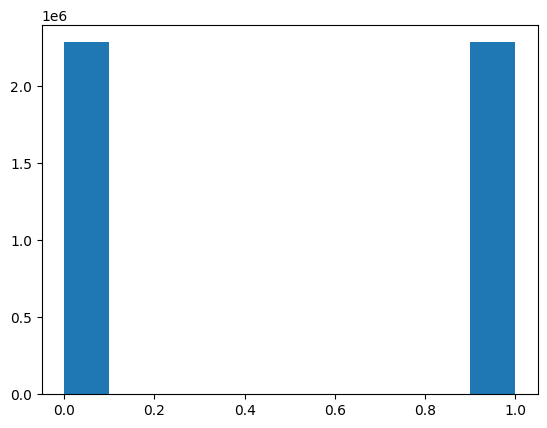

In [9]:
# plot distribution of samples
import matplotlib.pyplot as plt

plt.hist(samples_y)

In [10]:
# scale the x values
from sklearn.preprocessing import StandardScaler

def preprocess(x, y):
    scaler = StandardScaler()
    x = scaler.fit_transform(x)
    y = np.array(pd.get_dummies(y))
    return x, y, scaler

In [11]:
samples_x, samples_y, scaler = preprocess(samples_x, samples_y)

In [12]:
samples_x

array([[-0.52507518, -0.77079049, -0.37407598, ..., -0.4488831 ,
        -0.62258017, -0.68801137],
       [-0.72447352, -0.45196129, -0.31662125, ..., -0.50696168,
        -0.59661478, -0.84635977],
       [-0.3826478 , -0.39882309, -0.46025808, ..., -0.47792239,
        -0.77837246, -1.00470816],
       ...,
       [ 0.98465507,  0.90306281,  0.54519974, ...,  1.03212087,
         0.59779281,  0.98595739],
       [ 0.84222769,  0.74364821,  0.86120077, ...,  0.62557076,
         0.77955049,  0.85023019],
       [ 0.78525673,  0.79678641,  0.86120077, ...,  1.17731734,
         0.72761972,  0.75974539]])

In [13]:
samples_y

array([[1, 0],
       [1, 0],
       [1, 0],
       ...,
       [0, 1],
       [0, 1],
       [0, 1]], dtype=uint8)

In [14]:
from sklearn.model_selection import train_test_split

train_x, test_x, train_y, test_y = train_test_split(samples_x, samples_y, test_size=0.2)

In [15]:
`from keras import Sequential
from keras.layers import Dense

# implement a simple neural network
def build_model(length_x):
    model = Sequential([
        Dense(32, activation='swish', input_shape=(length_x,)),
        Dense(2, activation='softmax')
    ])
    
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model`

In [16]:
from keras.callbacks import EarlyStopping
callbacks = [
    EarlyStopping(
        # Stop training when `val_loss` is no longer improving
        monitor="val_loss",
        # "no longer improving" being defined as "no better than 1e-2 less"
        min_delta=1e-2,
        # "no longer improving" being further defined as "for at least 2 epochs"
        patience=5,
        verbose=1,
    )
]

dnn_model = build_model(len(samples_x[0]))

dnn_model.fit(
    train_x,
    train_y,
    epochs=100,
    callbacks=callbacks,
    batch_size=2048,
    validation_split=0.2,
    verbose=1,
)

2023-08-02 15:52:40.624176: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2023-08-02 15:52:40.624214: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2023-08-02 15:52:40.624224: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2023-08-02 15:52:40.624713: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-08-02 15:52:40.624984: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Epoch 1/100


2023-08-02 15:52:41.215764: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1427/1427 [==============================] - ETA: 0s - loss: 0.1592 - accuracy: 0.9360

2023-08-02 15:52:56.014430: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1427/1427 [==============================] - 19s 12ms/step - loss: 0.1592 - accuracy: 0.9360 - val_loss: 0.0417 - val_accuracy: 0.9884
Epoch 2/100
1427/1427 [==============================] - 18s 13ms/step - loss: 0.0349 - accuracy: 0.9899 - val_loss: 0.0321 - val_accuracy: 0.9903
Epoch 3/100
1427/1427 [==============================] - 17s 12ms/step - loss: 0.0312 - accuracy: 0.9905 - val_loss: 0.0310 - val_accuracy: 0.9906
Epoch 4/100
1427/1427 [==============================] - 18s 13ms/step - loss: 0.0305 - accuracy: 0.9907 - val_loss: 0.0304 - val_accuracy: 0.9909
Epoch 5/100
1427/1427 [==============================] - 17s 12ms/step - loss: 0.0292 - accuracy: 0.9912 - val_loss: 0.0286 - val_accuracy: 0.9912
Epoch 6/100
1427/1427 [==============================] - 18s 13ms/step - loss: 0.0269 - accuracy: 0.9922 - val_loss: 0.0259 - val_accuracy: 0.9925
Epoch 7/100
1427/1427 [==============================] - 19s 13ms/step - loss: 0.0246 - accuracy: 0.9930 - val_loss: 0.0238 - val_

In [17]:
dnn_model.evaluate(test_x, test_y, batch_size=512, return_dict=True)

1783/1783 [==============================] - 15s 9ms/step - loss: 0.0222 - accuracy: 0.9937


{'loss': 0.022204220294952393, 'accuracy': 0.9937154650688171}

In [18]:
# calculate the accuracy if we always predict [1, 0] to be the output
from sklearn.metrics import accuracy_score

accuracy_score(test_y, np.array([[1, 0]] * len(test_y)))

0.5009311211355735

In [34]:
# find the index of a [0, 1] example in the test y
dnn_model.predict([test_x[1:2]])

1/1 [==============================] - 0s 19ms/step


array([[1.4591686e-07, 9.9999988e-01]], dtype=float32)

# Results
The model is able to be very accurate, but this relies purely on temperature data. Before we move on to NLP and text analysis, let's try implementing an LSTM for this problem

# Experiment #2: Predicting fire alerts using temperature readings with an LSTM
The LSTM will take in the temperature readings from the past 7 days and output a prediction for the 7th day.

In [35]:
lstm_train_x = train_x.reshape((train_x.shape[0], train_x.shape[1], 1))
lstm_test_x = test_x.reshape((test_x.shape[0], test_x.shape[1], 1))

In [36]:
from keras.layers import LSTM

def build_lstm_model(length_x):
    model = Sequential([
        LSTM(50, activation='relu', input_shape=(length_x, 1)),
        Dense(2, activation='softmax')
    ])
    
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [38]:
lstm_model = build_lstm_model(len(samples_x[0]))

lstm_model.fit(
    lstm_train_x,
    train_y,
    epochs=100,
    callbacks=callbacks,
    batch_size=4096,
    validation_split=0.2,
    verbose=1,
)

Epoch 1/100


2023-08-02 16:00:08.319219: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


714/714 [==============================] - ETA: 0s - loss: 0.1198 - accuracy: 0.9583

2023-08-02 16:01:14.288940: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


714/714 [==============================] - 70s 97ms/step - loss: 0.1198 - accuracy: 0.9583 - val_loss: 0.0360 - val_accuracy: 0.9892
Epoch 2/100
714/714 [==============================] - 86s 121ms/step - loss: 0.0387 - accuracy: 0.9884 - val_loss: 0.0311 - val_accuracy: 0.9910
Epoch 3/100
714/714 [==============================] - 92s 129ms/step - loss: 0.0298 - accuracy: 0.9910 - val_loss: 0.0360 - val_accuracy: 0.9879
Epoch 4/100
714/714 [==============================] - 95s 133ms/step - loss: 0.0278 - accuracy: 0.9916 - val_loss: 0.0264 - val_accuracy: 0.9923
Epoch 5/100
714/714 [==============================] - 98s 137ms/step - loss: 0.0257 - accuracy: 0.9922 - val_loss: 0.0279 - val_accuracy: 0.9919
Epoch 6/100
714/714 [==============================] - 93s 130ms/step - loss: 0.0243 - accuracy: 0.9927 - val_loss: 0.0238 - val_accuracy: 0.9932
Epoch 7/100
714/714 [==============================] - 100s 140ms/step - loss: 0.0230 - accuracy: 0.9932 - val_loss: 0.0217 - val_accurac

In [39]:
lstm_model.evaluate(lstm_test_x, test_y, batch_size=4096, return_dict=True)

223/223 [==============================] - 5s 22ms/step - loss: 0.0196 - accuracy: 0.9942


{'loss': 0.01963375322520733, 'accuracy': 0.994205117225647}

In [40]:
dnn_model.save('dnn_model.h5')
lstm_model.save('lstm_model.h5')

/Users/alanalwakeel/miniconda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
